In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, shutil, random
from tqdm import tqdm

In [3]:
CONFIG = {
    'image_size': (224, 224),
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 100,
    'patience': 5,
    'min_lr': 1e-6,
    'weight_decay': 1e-4,
    'img_shape': (224, 224, 3),
}

In [4]:
SOURCE_DIR = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'
TARGET_DIR = '/kaggle/working/split_data'

In [5]:
CLASSES = sorted(os.listdir(SOURCE_DIR))
print("Classes:", CLASSES)

Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


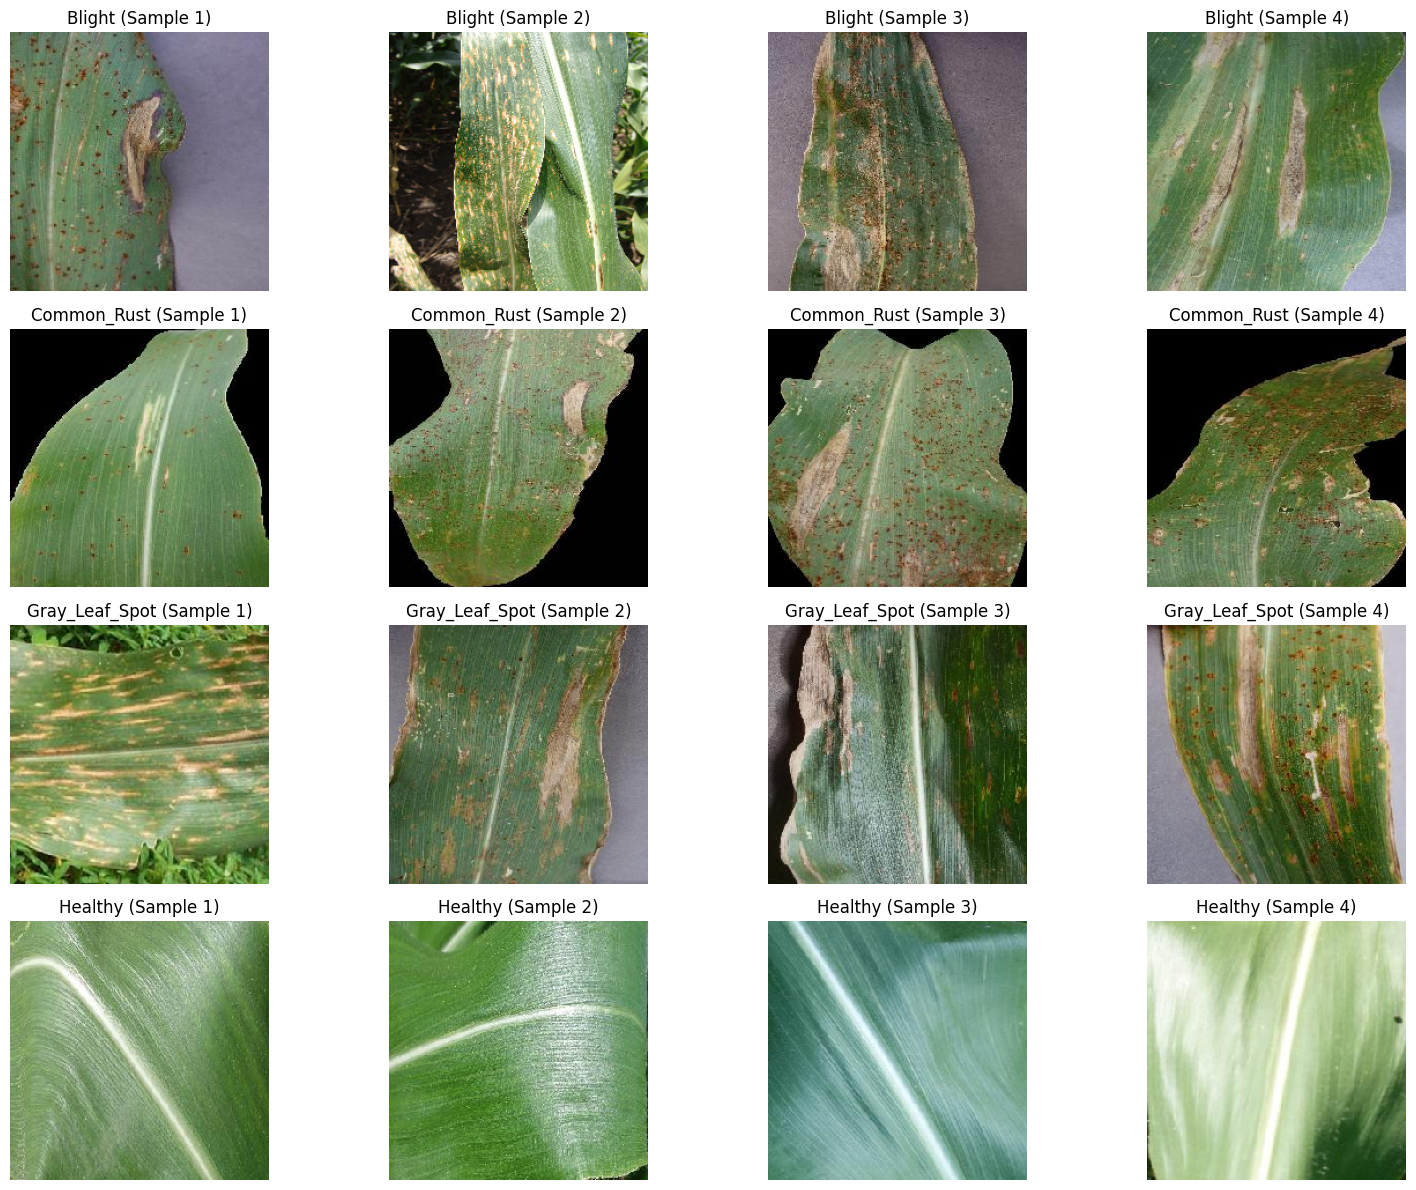

In [8]:
IMG_SIZE = (224, 224)
SAMPLES_PER_CLASS = 4

plt.figure(figsize=(16, 12))

for idx, label in enumerate(CLASSES):
    class_dir = os.path.join(SOURCE_DIR, label)
    images = os.listdir(class_dir)[:SAMPLES_PER_CLASS]
    
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)
        
        plt.subplot(len(CLASSES), SAMPLES_PER_CLASS, idx * SAMPLES_PER_CLASS + i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label} (Sample {i+1})", fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
SPLITS = ['train', 'val', 'test']

for split in SPLITS:
    for class_name in CLASSES:
        os.makedirs(os.path.join(TARGET_DIR, split, class_name), exist_ok=True)

for class_name in tqdm(CLASSES):
    class_path = os.path.join(SOURCE_DIR, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    for fname in train_files:
        shutil.copy(os.path.join(class_path, fname), os.path.join(TARGET_DIR, 'train', class_name, fname))
    for fname in val_files:
        shutil.copy(os.path.join(class_path, fname), os.path.join(TARGET_DIR, 'val', class_name, fname))
    for fname in test_files:
        shutil.copy(os.path.join(class_path, fname), os.path.join(TARGET_DIR, 'test', class_name, fname))

100%|██████████| 4/4 [00:32<00:00,  8.10s/it]


In [10]:
def get_data_generators(train_dir, val_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.8, 1.2),
        zoom_range=0.2,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=CONFIG['image_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=CONFIG['image_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        shuffle=False
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=CONFIG['image_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

train_dir = os.path.join(TARGET_DIR, 'train')
val_dir = os.path.join(TARGET_DIR, 'val')
test_dir = os.path.join(TARGET_DIR, 'test')

train_gen, val_gen, test_gen = get_data_generators(train_dir, val_dir, test_dir)
CONFIG['num_classes'] = train_gen.num_classes
print(f"\n✅ NUM_CLASSES detected: {CONFIG['num_classes']}")

Found 3348 images belonging to 4 classes.
Found 417 images belonging to 4 classes.
Found 423 images belonging to 4 classes.

✅ NUM_CLASSES detected: 4


In [11]:
def cbam_block(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    shared_mlp = models.Sequential([
        layers.Dense(channel // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(CONFIG['weight_decay'])),
        layers.Dense(channel, kernel_regularizer=regularizers.l2(CONFIG['weight_decay']))
    ])

    avg_out = shared_mlp(avg_pool)
    max_out = shared_mlp(max_pool)
    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = layers.Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [12]:
def build_model():
    inputs = layers.Input(shape=CONFIG['img_shape'])
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=CONFIG['img_shape'])
    base_model.trainable = True  # Freeze all layers

    x = base_model(inputs, training=False)
    x = cbam_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(CONFIG['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(CONFIG['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(CONFIG['num_classes'], activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

In [13]:
#Build the model
model = build_model()

I0000 00:00:1752226898.276025      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752226898.276742      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
def train_model(model, train_generator, val_generator):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=CONFIG['patience'], restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=CONFIG['min_lr'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=CONFIG['epochs'],
        callbacks=[early_stop, reduce_lr]
    )
    return history

# Train
history = train_model(model, train_gen, val_gen)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 132s 684ms/step - accuracy: 0.6598 - loss: 1.3421 - val_accuracy: 0.3118 - val_loss: 6.6435 - learning_rate: 0.0010
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 434ms/step - accuracy: 0.8545 - loss: 0.8381 - val_accuracy: 0.3094 - val_loss: 6.8402 - learning_rate: 0.0010
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - accuracy: 0.8883 - loss: 0.7453 - val_accuracy: 0.3070 - val_loss: 2.8437 - learning_rate: 0.0010
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 431ms/step - accuracy: 0.9119 - loss: 0.6941 - val_accuracy: 0.3885 - val_loss: 1.8109 - learning_rate: 0.0010
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 427ms/step - accuracy: 0.9297 - loss: 0.6551 - val_accuracy: 0.3549 - val_loss: 2.8737 - learning_rate: 0.0010
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 429ms/step - accuracy: 0.9368 - loss: 0.6244 - val_accuracy: 0.6571 - val_loss: 1.5582 - learning_rate: 0.0010
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 425ms/step - accur

In [18]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """Plot training & validation loss and accuracy curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

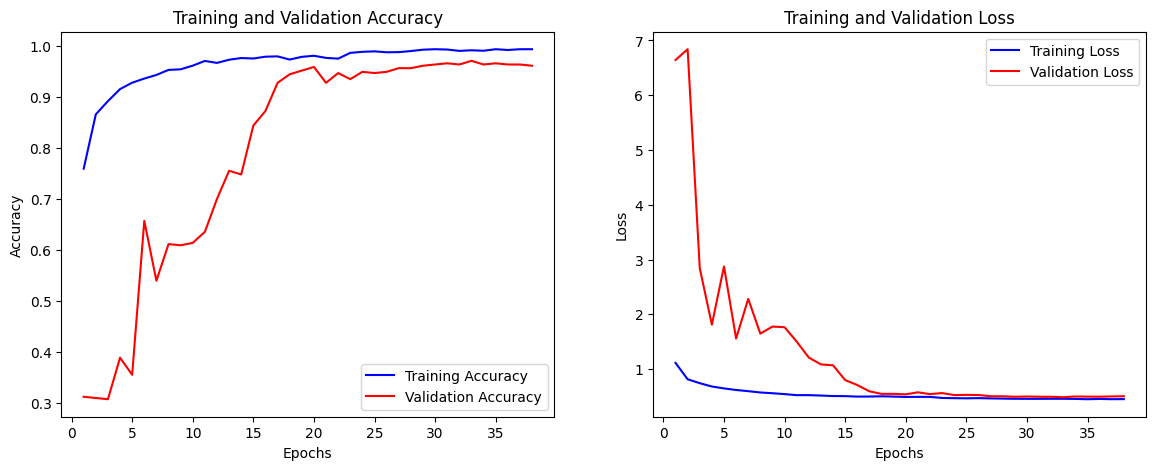

In [19]:
plot_training_curves(history)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9664 - loss: 0.4944

✅ Test Loss: 0.4809
✅ Test Accuracy: 97.16%
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

✅ Overall Test Set Metrics (Weighted Average):
Precision: 0.9714
Recall:    0.9716
F1-score:  0.9715

📈 Classification Report (Per Class):
                precision    recall  f1-score   support

        Blight       0.95      0.95      0.95       116
   Common_Rust       0.99      1.00      1.00       132
Gray_Leaf_Spot       0.91      0.90      0.90        58
       Healthy       1.00      1.00      1.00       117

      accuracy                           0.97       423
     macro avg       0.96      0.96      0.96       423
  weighted avg       0.97      0.97      0.97       423



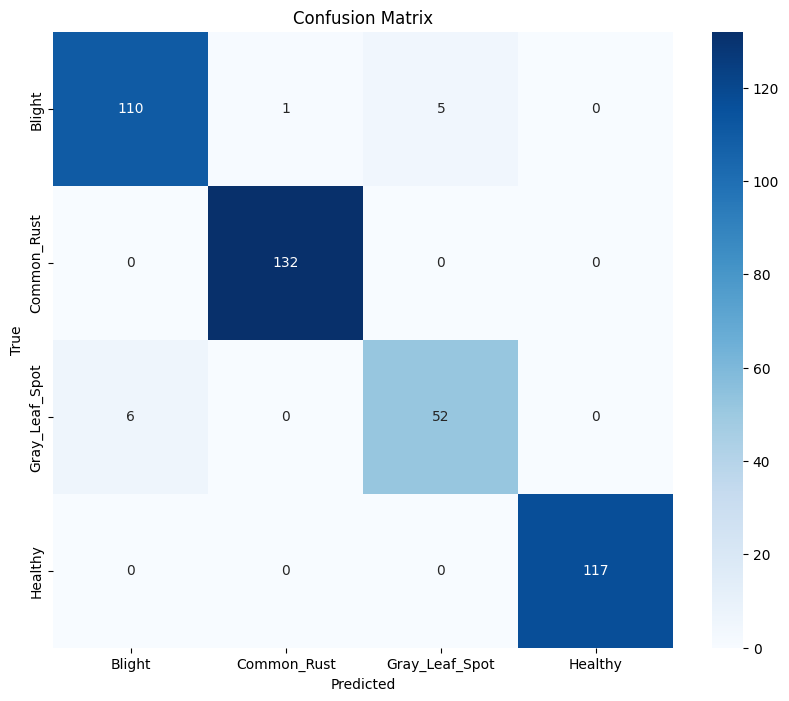

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# Predict
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

#Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract weighted average
weighted_precision = report['weighted avg']['precision']
weighted_recall    = report['weighted avg']['recall']
weighted_f1        = report['weighted avg']['f1-score']

print("\n✅ Overall Test Set Metrics (Weighted Average):")
print(f"Precision: {weighted_precision:.4f}")
print(f"Recall:    {weighted_recall:.4f}")
print(f"F1-score:  {weighted_f1:.4f}")


print("\n📈 Classification Report (Per Class):")
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()